# 1. Import

In [1]:
!pip install catboost

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import gc
import warnings
warnings.filterwarnings("ignore")

from tqdm import tqdm

# Data Wrangling
import pandas as pd
from pandas import Series, DataFrame
import numpy as np

# Visualization
import matplotlib.pylab as plt
from matplotlib import font_manager, rc
import seaborn as sns

# Preprocessing & Feature Engineering
from sklearn.model_selection import train_test_split

# Modeling
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

# Evaluation
from sklearn.metrics import *

# Utility
import os
import time
import random
import warnings; warnings.filterwarnings("ignore")
from IPython.display import Image
import pickle
from tqdm import tqdm, tqdm_notebook
import platform
from itertools import combinations

# 2. Read Data

In [2]:
panel = pd.read_csv(os.path.abspath("../input") + '/panel.csv')
survey = pd.read_csv(os.path.abspath("../input") + '/survey.csv')
response_train = pd.read_csv(os.path.abspath("../input") + '/response_train.csv')
response_test = pd.read_csv(os.path.abspath("../input") + '/response_test.csv')

__< 데이터 설명 >__  
  
* __panel__  
  
`GENDER` : 성별 - 1:남자 / 2:여자  
`REGION` : 지역  
`SQ1 ~ DQ7` : 설문조사 질문 설명  
  
* __Survey__  
  
`IR` : 난이도(응답가능성, 100이 최고) - 수치가 높으면 난이도가 높음  
`LOI` : 설문하는데 걸리는 시간 (분단위)  
`CPI` : 패널 응답 리워드 포인트 (1P~)  
  
* __Response_train__  
  
`ID` : submission을 식별하기 위한 ID로 사용

# 3. Data Cleansing

### panel

In [3]:
# panel 결측치 개수 확인
panel.isna().sum().sum()

218809

In [4]:
# BIRTH 대체할 결측치 확인
panel.BIRTH.value_counts().sort_values(ascending = False).index[0]

1982.0

In [5]:
# GENDER 대체할 결측치 확인
panel.GENDER.value_counts().sort_values(ascending = False).index[0]

2.0

In [6]:
# REGION 대체할 결측치 확인
panel.REGION.value_counts().sort_values(ascending = False).index[0]

2.0

In [7]:
# 결측치 처리
panel.BIRTH.fillna(panel.BIRTH.value_counts().sort_values(ascending = False).index[0],inplace = True)
panel.GENDER.fillna(panel.GENDER.value_counts().sort_values(ascending = False).index[0], inplace = True)
panel.REGION.fillna(panel.REGION.value_counts().sort_values(ascending = False).index[0],inplace = True)

## 나머지 데이터는 설문조사 결과이므로 0으로 처리
panel.fillna(0,inplace = True)

In [8]:
# 결측치 처리 후 확인
panel.isna().sum().sum()

0

### 질문 데이터 전처리

__< 처리 방법 >__  
  
* ',' , '.' 으로 이루어진 값을 `split`을 통해 응답값 통일화  
* 질문 선지에 없는 답이 명시되어 있는 경우 : __-1__  
* 멀티값인 경우 : __-2__

SQ1 - 성별

In [9]:
# `GENDER`열이 존재하기 때문에 삭제
panel = panel.drop(columns = ['SQ1'])

SQ2 - 출생년도

In [10]:
# error로 변환
panel.loc[panel['SQ2'] == 1 , 'SQ2'] = -1

# BIRTH와 SQ2의 답이 다른 경우 error로 변환
panel.loc[panel['SQ2'] != panel['BIRTH'] , 'SQ2'] = -1

# int 변환
panel['SQ2'] = panel['SQ2'].astype(int)

SQ3 - 사는 지역

In [11]:
panel['SQ3'] = panel['SQ3'].astype(str)
panel['SQ3'] = panel.SQ3.apply(lambda x : x.split('.')[0] if '.' in x else x).apply(lambda x : x.split(',')[0] if ',' in x else x)
panel['SQ3'] = panel['SQ3'].astype(int)

SQ4 - 사는 곳 유형

In [12]:
# SQ4 질문의 답
lst_SQ4 = list(np.arange(0,7,1).astype(str));lst_SQ4.append('97');lst_SQ4.append('-2')

In [13]:
panel['SQ4'] = panel['SQ4'].astype(str)
panel['SQ4'] = panel.SQ4.apply(lambda x : x.split(',')[0] if x.split(',')[0] == '97' else x).apply(lambda x : x.split(',')[0] if len(x) < 3 else x).apply(lambda x : x if x in lst_SQ4 else -1)
panel['SQ4'] = panel['SQ4'].astype(int)

SQ5 - 최종학력

In [14]:
# SQ5 질문의 답
lst_SQ5 = list(np.arange(0,5,1).astype(str))

In [15]:
panel['SQ5'] = panel['SQ5'].astype(str)
panel['SQ5'] = panel.SQ5.apply(lambda x : x if x in lst_SQ5  else '-1')
panel['SQ5'] = panel['SQ5'].astype(int)

SQ6 - 결혼 유무

In [16]:
# SQ6 질문의 답
lst_SQ6 = list(np.arange(0,3,1).astype(str));lst_SQ6.append('97');lst_SQ6.append('-2')

In [17]:
panel['SQ6'] = panel['SQ6'].astype(str)
panel['SQ6'] = panel.SQ6.apply(lambda x : x.split(',')[0] if x.split(',')[0] == '97' else x).apply(lambda x : x.split(',')[0] if len(x) <= 5 else x).apply(lambda x : x if x in lst_SQ6 else -1)
panel['SQ6'] = panel['SQ6'].astype(int)

SQ7 - 자녀 나이

In [18]:
# SQ7 질문의 답
lst_SQ7 = list(np.arange(0,17,1).astype(str));lst_SQ7.append('99')

In [19]:
panel['SQ7'] = panel['SQ7'].astype(str)
panel['SQ7'] = panel.SQ7.apply(lambda x : x.split('.')[0] if x.split('.')[0] == '99' else x).apply(lambda x : x.split('.')[0] if x.split('.')[0] in lst_SQ7 else x).apply(lambda x : x if x in lst_SQ7 else -1)
panel['SQ7'] = panel['SQ7'].astype(int)

SQ8 - 가족 수

In [20]:
# SQ8 질문의 답
lst_SQ8 = list(np.arange(0,6,1).astype(str))

In [21]:
panel['SQ8'] = panel['SQ8'].astype(str)
panel['SQ8'] = panel.SQ8.apply(lambda x : x if x in lst_SQ8 else '-1')
panel['SQ8'] = panel['SQ8'].astype(int)

A1 - 최근 1년이내 구입한 가전제품 __(multi)__

In [22]:
# A1 질문의 답
lst_A1 = list(np.arange(0,23,1).astype(str));lst_A1.append('99');lst_A1.append('-2')

In [23]:
panel['A1'] = panel['A1'].astype(str)
panel['A1'] = panel.A1.apply(lambda x : x.split('.')[0] if x.split('.')[0] in lst_A1 and len(x) <= 3 else x).apply(lambda x : -2 if len(x) >=3 else x).apply(lambda x : x if x in lst_A1 else '-1')
panel['A1'] = panel['A1'].astype(int)

B1 - 휴대폰 인터넷 통신망  
  

In [24]:
panel.B1.value_counts()

0               3598
4               3134
1               2706
99              1720
8               1642
                ... 
1,10,2,3,4,8       1
1,10,2,9           1
1,10,2,5,6,9       1
1,6                1
1,4,6,7            1
Name: B1, Length: 119, dtype: int64

In [25]:
# B1에 해당하는 답들이 아니라고 판단하여 삭제
panel = panel.drop(columns = ['B1'])

B2 - 휴대폰 통신사  


In [26]:
panel.B2.value_counts()

0              3981
1              3869
3              1765
99             1360
2              1311
               ... 
2,3,4,6,7,9       1
97,11             1
97,redmi          1
10,5,7,8          1
1,2,3,5,6         1
Name: B2, Length: 109, dtype: int64

In [27]:
# B2에 해당하는 답들이 아니라고 판단하여 삭제
panel = panel.drop(columns = ['B2'])

B3 - 휴대폰 제조사  

In [28]:
# B3 질문의 답
lst_B3 = list(np.arange(0,8,1).astype(str));lst_B3.append('99');lst_B3.append('-2');lst_B3.append('97')

In [29]:
panel['B3'] = panel['B3'].astype(str)

# 9997 -> 현재 사용 중인 휴대폰 없음으로 처리
panel.loc[panel['B3'] == '9997', 'B3'] == '99'
panel['B3'] = panel.B3.apply(lambda x : x.split(',')[0] if x.split(',')[0] == '97' else x).apply(lambda x : -1 if len(x) >=3 else x).apply(lambda x : x if x in lst_B3 else '-1')
panel['B3'] = panel['B3'].astype(int)

B4 - 사용하는 스마트 기기 __(multi)__

In [30]:
# B4 질문의 답
lst_B4 = list(np.arange(0,9,1).astype(str));lst_B4.append('99');lst_B4.append('-2');lst_B4.append('97')

In [31]:
panel['B4'] = panel['B4'].astype(str)
panel['B4'] =panel.B4.apply(lambda x : x.split(',')[0] if x.split(',')[0] == '97' else x).apply(lambda x : '-2' if len(x) >=3 else x).apply(lambda x : x if x in lst_B4 else '-1')
panel['B4'] = panel['B4'].astype(int)

B5 - TV 케이블 망

In [32]:
# B5 질문의 답
lst_B5 = list(np.arange(0,11,1).astype(str));lst_B5.append('99');lst_B5.append('-2');lst_B5.append('97')

In [33]:
panel['B5'] = panel['B5'].astype(str)
panel['B5'] =panel.B5.apply(lambda x : x.split(',')[0] if x.split(',')[0] == '97' else x).apply(lambda x : x.split(',')[0] if x.split(',')[0] in lst_B5 and len(x) <= 3 else x).apply(lambda x : x if x in lst_B5 else '-1')
panel['B5'] = panel['B5'].astype(int)

C1 - 가입 보험 종류 __(multi)__

In [34]:
# C1 질문의 답
lst_C1 = list(np.arange(0,16,1).astype(str));lst_C1.append('99');lst_C1.append('-2')

In [35]:
panel['C1'] = panel['C1'].astype(str)
panel['C1'] =panel.C1.apply(lambda x : x.split(',')[0] if x.split(',')[0] == '99' else x).apply(lambda x : x.split(',')[0] if x.split(',')[0] in lst_C1 and len(x) <= 3 else x).apply(lambda x : '-2' if len(x) >=3 else x).apply(lambda x : x if x in lst_C1 else '-1')
panel['C1'] = panel['C1'].astype(int)

C2 - 주 거래 은행

In [36]:
# C2 질문의 답
lst_C2 = list(np.arange(0,15,1).astype(str));lst_C2.append('97')

In [37]:
panel['C2'] = panel['C2'].astype(str)
panel['C2'] =panel.C2.apply(lambda x : x.split(',')[0] if x.split(',')[0] == '97' else x).apply(lambda x : x.split(',')[0] if x.split(',')[0] in lst_C2 and len(x) <= 3 else x).apply(lambda x : x if x in lst_C2 else '-1')
panel['C2'] = panel['C2'].astype(int)

C3 - 사용중인 간편결제서비스 __(multi)__

In [38]:
# C3 질문의 답
lst_C3 = list(np.arange(0,11,1).astype(str));lst_C3.append('97');lst_C3.append('99');lst_C3.append('-2')

In [39]:
panel['C3'] = panel['C3'].astype(str)
panel['C3'] =panel.C3.apply(lambda x : x.split(',')[0] if x.split(',')[0] == '97' else x).apply(lambda x : x.split(',')[0] if x.split(',')[0] in lst_C3 and len(x) <= 3 else x).apply(lambda x : '-2' if len(x) >=3 else x).apply(lambda x : x if x in lst_C3 else '-1')
panel['C3'] = panel['C3'].astype(int)

F1 - 주로 이용하는 대형할인마트

In [40]:
# F1 질문의 답
lst_F1 = list(np.arange(0,11,1).astype(str));lst_F1.append('97');lst_F1.append('99')

In [41]:
panel['F1'] = panel['F1'].astype(str)
panel['F1'] =panel.F1.apply(lambda x : x.split(',')[0] if x.split(',')[0] == '97' else x).apply(lambda x : x.split(',')[0] if x.split(',')[0] in lst_F1 and len(x) <= 3 else x).apply(lambda x : x if x in lst_F1 else '-1')
panel['F1'] = panel['F1'].astype(int)

F2 - 주로 이용하는 온라인 대형할인마트

In [42]:
# F2 질문의 답
lst_F2 = list(np.arange(0,6,1).astype(str));lst_F2.append('97');lst_F2.append('99')

In [43]:
panel['F2'] = panel['F2'].astype(str)
panel['F2'] =panel.F2.apply(lambda x : x.split(',')[0] if x.split(',')[0] == '97' else x).apply(lambda x : x.split(',')[0] if x.split(',')[0] in lst_F2 and len(x) <= 3 else x).apply(lambda x : x if x in lst_F2 else '-1')
panel['F2'] = panel['F2'].astype(int)

H1 - 3개월간 음용한 주류

In [44]:
# H1 질문의 답
lst_H1 = list(np.arange(0,12,1).astype(str));lst_H1.append('97');lst_H1.append('99')

In [45]:
panel['H1'] = panel['H1'].astype(str)
panel['H1'] =panel.H1.apply(lambda x : '-2' if len(x) >=3 else x).apply(lambda x : x if x in lst_H1 else '-1')
panel['H1'] = panel['H1'].astype(int)

T1 - 피우는 담배 브랜드

In [46]:
# T1 질문의 답
lst_T1 = list(np.arange(0,34,1).astype(str));lst_T1.append('971');lst_T1.append('972');lst_T1.append('99')

In [47]:
panel['T1'] = panel['T1'].astype(str)

# 9997 -> 담배 피우지 않음으로 처리
panel.loc[panel['T1'] == '9997', 'T1'] == '99'
panel['T1'] =panel.T1.apply(lambda x : x.split(',')[0] if x.split(',')[0] == '971' else x).apply(lambda x : x.split(',')[0] if x.split(',')[0] == '972' else x).apply(lambda x : x.split(',')[0] if x.split(',')[0] in lst_T1 else x).apply(lambda x : x if x in lst_T1 else '-1')
panel['T1'] = panel['T1'].astype(int)

X1 - 주로 운전하는 자동차의 제조사

In [48]:
# X1 질문의 답
lst_X1 = list(np.arange(0,26,1).astype(str));lst_X1.append('97');lst_X1.append('99')

In [49]:
panel['X1'] = panel['X1'].astype(str)
panel['X1'] =panel.X1.apply(lambda x : x.split(',')[0] if x.split(',')[0] == '97' else x).apply(lambda x : x.split(',')[0] if x.split(',')[0] in lst_X1 else x).apply(lambda x : x if x in lst_X1 else '-1')
panel['X1'] = panel['X1'].astype(int)

X2 - 자동차 구매 형태

In [50]:
panel.X2.value_counts()

0          8799
1.0        2186
99.0       1119
2.0         629
1           469
4.0         459
3.0         429
5.0         406
6.0         367
11.0        237
7.0         217
8.0         186
9.0         180
2           109
10.0         88
99           86
21.0         64
12.0         42
4            38
5            38
16.0         37
1.0          31
20.0         28
13.0         28
6            27
8            24
14.0         23
19.0         22
3            21
97.0         21
7            19
98.0         18
17.0         13
6.0          12
99.0         10
15.0          9
2.0           8
98            7
11            7
3.0           7
9             7
18.0          6
4.0           5
5.0           4
10            3
7.0           3
12            3
22.0          2
21.0          2
8.0           2
97,프리랜서       1
14.0          1
11.0          1
10.0          1
9.0           1
14            1
Name: X2, dtype: int64

In [51]:
# X2에 해당하는 답들이 아니라고 판단하여 삭제
panel = panel.drop(columns = ['X2'])

X3 - 자주 이용하는 주유소

In [52]:
# X3 질문의 답
lst_X3 = list(np.arange(0,9,1).astype(str));lst_X3.append('97');lst_X3.append('99')

In [53]:
panel['X3'] = panel['X3'].astype(str)
panel['X3'] =panel.X3.apply(lambda x : x.split(',')[0] if x.split(',')[0] == '97' else x).apply(lambda x : x.split(',')[0] if x.split(',')[0] in lst_X3 else x).apply(lambda x : x if x in lst_X3 else '-1')
panel['X3'] = panel['X3'].astype(int)

X4 - 주 자동차 연료 타입

In [54]:
# X4 질문의 답
lst_X4 = list(np.arange(0,5,1).astype(str));lst_X4.append('97');lst_X4.append('99')

In [55]:
panel['X4'] = panel['X4'].astype(str)
panel['X4'] =panel.X4.apply(lambda x : x.split(',')[0] if x.split(',')[0] == '97' else x).apply(lambda x : x.split('.')[0] if x.split('.')[0] in lst_X4 else x).apply(lambda x : x if x in lst_X4 else '-1')
panel['X4'] = panel['X4'].astype(int)

DQ1 - 직업

In [56]:
# DQ1 질문의 답
lst_DQ1 = list(np.arange(0,16,1).astype(str));lst_DQ1.append('97');lst_DQ1.append('99')

In [57]:
panel['DQ1'] = panel['DQ1'].astype(str)
panel['DQ1'] =panel.DQ1.apply(lambda x : x.split(',')[0] if x.split(',')[0] == '97' else x).apply(lambda x : x.split(',')[0] if x.split(',')[0] in lst_DQ1 else x).apply(lambda x : x if x in lst_DQ1 else '-1')
panel['DQ1'] = panel['DQ1'].astype(int)

DQ2 - 근무하는 직종

In [58]:
# DQ2 질문의 답
lst_DQ2 = list(np.arange(0,23,1).astype(str));lst_DQ2.append('97');lst_DQ2.append('99')

In [59]:
panel['DQ2'] = panel['DQ2'].astype(str)
panel['DQ2'] =panel.DQ2.apply(lambda x : x.split(',')[0] if x.split(',')[0] == '97' else x).apply(lambda x : x.split(',')[0] if x.split(',')[0] in lst_DQ2 else x).apply(lambda x : x if x in lst_DQ2 else '-1')
panel['DQ2'] = panel['DQ2'].astype(int)

DQ3 - 회사에서 담당하고 있는 직무분야

In [60]:
# DQ3 질문의 답
lst_DQ3 = list(np.arange(0,22,1).astype(str));lst_DQ3.append('97');lst_DQ3.append('99')

In [61]:
panel['DQ3'] = panel['DQ3'].astype(str)
panel['DQ3'] =panel.DQ3.apply(lambda x : x.split(',')[0] if x.split(',')[0] == '97' else x).apply(lambda x : x.split('.')[0] if x.split('.')[0] in lst_DQ3 else x).apply(lambda x : x if x in lst_DQ3 else '-1')
panel['DQ3'] = panel['DQ3'].astype(int)

DQ4 - 직장에서 직급

In [62]:
# DQ4 질문의 답
lst_DQ4 = list(np.arange(0,8,1).astype(str));lst_DQ4.append('97');lst_DQ4.append('99')

In [63]:
panel['DQ4'] = panel['DQ4'].astype(str)
panel['DQ4'] =panel.DQ4.apply(lambda x : x.split(',')[0] if x.split(',')[0] == '97' else x).apply(lambda x : x.split(',')[0] if x.split(',')[0] in lst_DQ4 else x).apply(lambda x : x if x in lst_DQ4 else '-1')
panel['DQ4'] = panel['DQ4'].astype(int)

DQ5 - 회사의 규모

In [64]:
panel['DQ5'] = panel['DQ5'].astype(int)

DQ6 - 한달 평균 가구소득

In [65]:
panel['DQ6'] = panel['DQ6'].astype(int)

DQ7 - 고용 형태

In [66]:
panel['DQ7'] = panel['DQ7'].astype(int)

### survey

In [67]:
survey.isna().sum()

surveyID         0
TITLE            0
IR               0
LOI              0
CATEGORIES    5027
CPI              0
dtype: int64

In [68]:
# CATEGORIES 열은 의미가 없다고 판단되어 삭제
survey.drop(columns  = 'CATEGORIES',inplace = True)

In [69]:
survey.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5976 entries, 0 to 5975
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   surveyID  5976 non-null   object 
 1   TITLE     5976 non-null   object 
 2   IR        5976 non-null   int64  
 3   LOI       5976 non-null   int64  
 4   CPI       5976 non-null   float64
dtypes: float64(1), int64(2), object(2)
memory usage: 233.6+ KB


### response_train

In [70]:
response_train.isna().sum()

userID      0
surveyID    0
TIME        0
STATUS      0
dtype: int64

### response_test

In [71]:
response_test.isna().sum()

ID          0
userID      0
surveyID    0
TIME        0
dtype: int64

### Merge Data

In [72]:
# 결측값 확인
for i in panel.columns:
    try:
        print( i,'//' ,np.sum(panel[i] == 0) / panel.shape[0])
    except:
        pass

userID // 0.0
BIRTH // 0.0
GENDER // 0.0
REGION // 0.0
TYPE // 0.0
SQ2 // 0.0
SQ3 // 0.09690273501177323
SQ4 // 0.0973253637626034
SQ5 // 0.15190484815552738
SQ6 // 0.15220672583469178
SQ7 // 0.1849906417919459
SQ8 // 0.18728491215359536
A1 // 0.20956348487592827
B3 // 0.24403791583650306
B4 // 0.25381875264142967
B5 // 0.26323733623135903
C1 // 0.3160659300851295
C2 // 0.41484030670772204
C3 // 0.4265531606593009
F1 // 0.4703857996739721
F2 // 0.4793213789772384
H1 // 0.4933285032904667
T1 // 0.49846042383626155
X1 // 0.5119845438628268
X3 // 0.5558775584133309
X4 // 0.6999335869105838
DQ1 // 0.7594034897059712
DQ2 // 0.7828895731449617
DQ3 // 0.7886856245849182
DQ4 // 0.790315764052406
DQ5 // 0.7946628026323733
DQ6 // 0.7953873090623679
DQ7 // 0.798406085854012


In [73]:
train = response_train.merge(survey).merge(panel, on = 'userID')
test = response_test.merge(survey).merge(panel, on = 'userID')

In [74]:
gc.collect()

40

# 4. Features Engineering

* 질문관련

In [75]:
train['error_sum'] = (train.loc[:,'SQ2':'DQ7']==0).sum(axis=1)
test['error_sum'] = (test.loc[:,'SQ2':'DQ7']==0).sum(axis=1)

* 분할

In [76]:
train.columns

Index(['userID', 'surveyID', 'TIME', 'STATUS', 'TITLE', 'IR', 'LOI', 'CPI',
       'BIRTH', 'GENDER', 'REGION', 'TYPE', 'SQ2', 'SQ3', 'SQ4', 'SQ5', 'SQ6',
       'SQ7', 'SQ8', 'A1', 'B3', 'B4', 'B5', 'C1', 'C2', 'C3', 'F1', 'F2',
       'H1', 'T1', 'X1', 'X3', 'X4', 'DQ1', 'DQ2', 'DQ3', 'DQ4', 'DQ5', 'DQ6',
       'DQ7', 'error_sum'],
      dtype='object')

In [77]:
train = train.drop([ 'C2', 'C3', 'F1', 'F2',
       'H1', 'T1', 'X1', 'X3', 'X4', 'DQ1', 'DQ2', 'DQ3', 'DQ4', 'DQ5', 'DQ6',
       'DQ7'],axis=1)

test = test.drop([ 'C2', 'C3', 'F1', 'F2',
       'H1', 'T1', 'X1', 'X3', 'X4', 'DQ1', 'DQ2', 'DQ3', 'DQ4', 'DQ5', 'DQ6',
       'DQ7'],axis=1)d

In [78]:

len(set(train.userID.unique())-set((test.userID.unique())))

891

In [79]:
# train 데이터 분할
before_train = train.query("TIME>='2020-11-01 00:00:00' and TIME< '2021-03-01 00:00:00'")
train = train.query("TIME>='2021-03-01 00:00:00'")

In [80]:
len(set(test.userID.unique()) - set(train.userID.unique()))

182

In [81]:
# month는 drop 예정
train['TIME'] =  pd.to_datetime(train['TIME'], format='%Y/%m/%d')
train['weekday'] = train['TIME'].dt.dayofweek
train['month'] = train['TIME'].dt.month
train['hour'] = train['TIME'].dt.hour

test['TIME'] =  pd.to_datetime(test['TIME'], format='%Y/%m/%d')
test['weekday'] = test['TIME'].dt.dayofweek
test['month'] = train['TIME'].dt.month
test['hour'] = test['TIME'].dt.hour

In [82]:
# 6~10월 요일 별 응답률
train_weekday_ratio = train.groupby('weekday')['STATUS'].mean().reset_index().rename(columns = {'STATUS' : 'STATUS_ratio_weekday'})

train = train.merge(train_weekday_ratio,on='weekday')
test = test.merge(train_weekday_ratio,on='weekday')
#tr_test = tr_test.merge(train_weekday_ratio,on='weekday')

In [83]:
# 6~10월 시간 별 응답률
train_hour_ratio = train.groupby('hour')['STATUS'].mean().reset_index().rename(columns = {'STATUS' : 'STATUS_ratio_hour'})

train = train.merge(train_hour_ratio,on='hour')
test = test.merge(train_hour_ratio,on='hour')
#tr_test = tr_test.merge(train_hour_ratio,on='hour')

In [84]:
IR_index = (before_train.query('STATUS == 1')['IR'].value_counts()/before_train.query('STATUS == 1')['IR'].value_counts().sum()).sort_values(ascending = False).head(2).index.tolist()
LOI_index = (before_train.query('STATUS == 1')['LOI'].value_counts()/before_train.query('STATUS == 1')['LOI'].value_counts().sum()).sort_values(ascending = False).head(5).index.tolist()
CPI_index = (before_train.query('STATUS == 1')['CPI'].value_counts()/before_train.query('STATUS == 1')['CPI'].value_counts().sum()).sort_values(ascending = False).head(5).index.tolist()

In [85]:
train['IR_ind'] = train['IR'].apply(lambda x : 1if x in IR_index else 0)
train['LOI_ind'] = train['LOI'].apply(lambda x : 1 if x in LOI_index else 0)
train['CPI_ind'] = train['CPI'].apply(lambda x : 1 if x in CPI_index else 0)
test['IR_ind'] = test['IR'].apply(lambda x : 1 if x in IR_index else 0)
test['LOI_ind'] = test['LOI'].apply(lambda x : 1 if x in LOI_index else 0)
test['CPI_ind'] = test['CPI'].apply(lambda x : 1 if x in CPI_index else 0)

* 응답 추세(2020/6~10)

In [86]:
week_to = train['TIME'].max()
week_trans = []
for i in range(6):
    week_from = week_to + pd.DateOffset(weeks=-1)
    week_trans.append(train.query('@week_from < TIME <= @week_to')
                      .groupby('userID')['STATUS']
                      .agg([(f'w{6-i}', 'mean')])
                      .reset_index())
    week_to = week_from
    #userID별 월별 응답 평균

In [87]:
# 리스트로부터 데이터프레임 변환    
f = pd.DataFrame({'userID': train.userID.unique()})

In [88]:
for w in week_trans[::-1]:
    f = f.merge(w,how='left',on='userID')

In [89]:
for i in f.columns[1:]:
    f[i] = f[i].fillna(f[i].mean())

In [90]:
train = train.merge(f, how='left')

In [91]:
test = test.merge(f, how='left')
#tr_test = tr_test.merge(f, how ='left')

In [92]:
test.w6.value_counts().sort_index()

0.000000    552583
0.018868      2551
0.019231       804
0.019608      1637
0.020833       657
             ...  
0.909091      2904
0.916667      2079
0.923077      1416
0.928571      1205
1.000000    205915
Name: w6, Length: 78, dtype: int64

In [93]:
for i in f.columns[1:]:
    test[i] = test[i].fillna(test[i].mean())

In [94]:
train.shape, test.shape

((1170545, 39), (1355517, 39))

In [95]:
gc.collect()

222

패널별 응답시, 리워드 난이도 시간 ~ before train

In [100]:
response_CPI = before_train[before_train.STATUS==1].groupby('userID')['CPI'].agg([
    ('TOT_CPI', lambda x: np.sum(x)),
    ('AVG_CPI', lambda x: np.mean(x)),
    ('MIN_CPI', lambda x: np.min(x)),
    ('MAX_CPI', lambda x: np.max(x))
]).reset_index()

In [101]:
response_IR = before_train[before_train.STATUS==1].groupby('userID')['IR'].agg([
    ('TOT_IR', lambda x: np.sum(x)),
    ('AVG_IR', lambda x: np.mean(x)),
    ('MIN_IR', lambda x: np.min(x)),
    ('MAX_IR', lambda x: np.max(x))
]).reset_index()

In [102]:
response_LOI = before_train[before_train.STATUS==1].groupby('userID')['IR'].agg([
    ('TOT_LOI', lambda x: np.sum(x)),
    ('AVG_LOI', lambda x: np.mean(x)),
    ('MIN_LOI', lambda x: np.min(x)),
    ('MAX_LOI', lambda x: np.max(x))
]).reset_index()

In [103]:
train = train.merge(response_CPI, how='left')
train = train.merge(response_IR, how='left')
train = train.merge(response_LOI, how='left')

In [104]:
train.fillna(0,inplace=True)

In [105]:
test = test.merge(response_CPI, how='left')
test = test.merge(response_IR, how='left')
test = test.merge(response_LOI, how='left')

In [106]:
test.fillna(0, inplace=True)

In [107]:
train.shape, test.shape

((1170545, 50), (1355517, 50))

* 군집분석

In [110]:
train = train.drop(columns = 'month')
test = test.drop(columns = 'month')

KeyError: "['month'] not found in axis"

In [111]:
from sklearn.cluster import KMeans

class KMeansFeaturizer:
    """ 숫자 데이터를 k-평균 클러스터 멤버십으로 변환.

    이 변환기는 입력 데이터에 k-평균을 수행해 각 데이터 포인트를 가장 가까운 클러스터의 id로 변환한다.
    만약 목표 변수가 주어지면 유사한 데이터 포인트와 함께 grouping되고,
    분류 경계에 따르는 클러스터를 생성하기 위해 스케일링되고, k-평균 입력에 포함된다.
    """

    def __init__(self, k = 30, target_scale = 5.0, random_state = None):
        self.k = k
        self.target_scale = target_scale
        self.random_state = random_state

    def fit(self, X, y = None):
        """ 입력 데이터에 k-평균을 수행하고 중심점을 찾는다.
        """
        if y is None: # 목표 변수가 없으면 단순한 k-평균 수행
            km_model = KMeans(n_clusters = self.k, n_init = 20, random_state = self.random_state)
            km_model.fit(X)
            
            self.inertia_ = km_model.inertia_
            self.km_model = km_model
            self.cluster_centers_ = km_model.cluster_centers_
            return self

        # 목표 변수가 있으면, 적절한 스케일링을 적용하고, 이를 k-평균에 대한 입력 데이터에 포함시킨다.
        data_with_target = np.hstack((X, y[:, np.newaxis] * self.target_scale))
        # 데이터와 타겟에 대해 사전 학습할 k-평균 모델 구축
        km_model_pretrain = KMeans(n_clusters = self.k, n_init = 20, random_state = self.random_state)
        km_model_pretrain.fit(data_with_target)

        # k평균을 두번째로 실행해 목표 변수 없이 원시 공간에서 클러스터를 얻는다. 사전 학습을 통해 얻은 중심점을 활용해 초기화한다.
        # 반복을 통해 클러스터 할당과 중심점 계산을 다시 수행한다.

        km_model = KMeans(n_clusters = self.k, init = km_model_pretrain.cluster_centers_[:,:data_with_target.shape[1]-1], n_init = 1, max_iter = 1)

        km_model.fit(X)
        
        self.inertia_ = km_model.inertia_
        self.km_model = km_model
        self.cluster_centers_ = km_model.cluster_centers_
        return self

    def transform(self, X, y = None):
        """ 각 입력 데이터 포인트에 대해 가장 가까운 클러스터 ID 산출
        """
        clusters = self.km_model.predict(X)
        return clusters[:, np.newaxis]

    def fit_transform(self, X, y = None):
        self.fit(X, y)
        return self.transform(X, y)

In [112]:
gc.collect()

29

In [113]:
train_num_features = train.select_dtypes(exclude=['object','datetime64[ns]'])
test_num_features = test.select_dtypes(exclude=['object','datetime64[ns]'])

In [114]:
km = KMeansFeaturizer(k=30,random_state = 42)

In [115]:
cus_train_kmean = km.fit_transform(train_num_features)
cus_test_kmean = km.transform(test_num_features)

In [116]:
cus_train_kmean = pd.DataFrame(cus_train_kmean).rename(columns = {0 : 'KMeans'})
cus_test_kmean = pd.DataFrame(cus_test_kmean).rename(columns = {0 : 'KMeans'})

In [117]:
train = pd.concat([train, cus_train_kmean], axis = 1)
test = pd.concat([test, cus_test_kmean], axis = 1)

In [118]:
train.shape, test.shape

((1170545, 51), (1355517, 51))

* BIRTH 이산화

In [119]:
train.loc[train.BIRTH < 1950,'BIRTH'] = 1940
train.loc[(1950 <=train.BIRTH) & (train.BIRTH < 1960),'BIRTH'] = 1950
train.loc[(1960 <= train.BIRTH) & (train.BIRTH < 1970),'BIRTH'] = 1960
train.loc[(1970 <=train.BIRTH) & (train.BIRTH < 1980),'BIRTH'] = 1970
train.loc[(1980 <=train.BIRTH) & (train.BIRTH < 1990),'BIRTH'] = 1980
train.loc[(1990 <=train.BIRTH) & (train.BIRTH < 2000),'BIRTH'] = 1990
train.loc[(2000 <=train.BIRTH) & (train.BIRTH < 2010),'BIRTH'] = 2000

#plt.plot(train.STATUS.groupby(train.BIRTH).sum() / train.STATUS.groupby(train.BIRTH).count())

# 나름대로 유의미?
train['BIRTH'] = train['BIRTH']

test.loc[test.BIRTH < 1950,'BIRTH'] = 1940
test.loc[(1950 <=test.BIRTH) & (test.BIRTH < 1960),'BIRTH'] = 1950
test.loc[(1960 <= test.BIRTH) & (test.BIRTH < 1970),'BIRTH'] = 1960
test.loc[(1970 <=test.BIRTH) & (test.BIRTH < 1980),'BIRTH'] = 1970
test.loc[(1980 <=test.BIRTH) & (test.BIRTH < 1990),'BIRTH'] = 1980
test.loc[(1990 <=test.BIRTH) & (test.BIRTH < 2000),'BIRTH'] = 1990
test.loc[(2000 <=test.BIRTH) & (test.BIRTH < 2010),'BIRTH'] = 2000

test['BIRTH'] = test['BIRTH']

# 5. Feature Selection

* 학습용 데이터들 만들기

In [120]:
X_train = train.iloc[:,5:]
y_train = train.STATUS
X_test = test.iloc[:,5:]
ID = test['ID']

In [121]:
 #범주형 변수와 수치형 변수를 분리
cat_features = ['BIRTH','GENDER','REGION','TYPE','SQ2','SQ3','SQ4','SQ5','SQ6','SQ7','SQ8','A1','B3','B4','B5','C1','weekday','hour', 'KMeans']
num_features = list(set(X_train.columns) - set(cat_features))

In [122]:
X_train.shape,X_test.shape

((1170545, 46), (1355517, 46))

In [123]:
X_train[cat_features] = X_train[cat_features].astype(str)

In [124]:
X_test[cat_features] = X_test[cat_features].astype(str)

In [125]:
gc.collect()

40

* 원핫 인코딩

In [126]:
# OneHotEncoding 변환
if len(cat_features) > 0:
    X_train = pd.concat([X_train[num_features], pd.get_dummies(X_train[cat_features])], axis=1)
    X_test = pd.concat([X_test[num_features], pd.get_dummies(X_test[cat_features])], axis=1)
else:
    X_train= X_train[num_features]
    X_test = test[num_features]
bag = (set(X_train.columns) - set(X_test.columns))
for i in bag:
    X_test[i] = 0

In [127]:
X_train.shape,X_test.shape

((1170545, 337), (1355517, 337))

In [128]:
list(set(X_train.columns) - set(X_test.columns))

[]

In [129]:
gc.collect()

60

### Shap

In [130]:
!pip install shap

Learning rate set to 0.210444
0:	learn: 0.5397757	total: 338ms	remaining: 5m 37s
1:	learn: 0.4560854	total: 524ms	remaining: 4m 21s
2:	learn: 0.4120235	total: 734ms	remaining: 4m 3s
3:	learn: 0.3877288	total: 942ms	remaining: 3m 54s
4:	learn: 0.3721383	total: 1.11s	remaining: 3m 41s
5:	learn: 0.3609054	total: 1.28s	remaining: 3m 33s
6:	learn: 0.3540719	total: 1.46s	remaining: 3m 26s
7:	learn: 0.3477825	total: 1.64s	remaining: 3m 23s
8:	learn: 0.3444790	total: 1.82s	remaining: 3m 20s
9:	learn: 0.3414914	total: 2.01s	remaining: 3m 19s
10:	learn: 0.3389120	total: 2.19s	remaining: 3m 17s
11:	learn: 0.3371746	total: 2.39s	remaining: 3m 16s
12:	learn: 0.3355857	total: 2.56s	remaining: 3m 14s
13:	learn: 0.3339074	total: 2.73s	remaining: 3m 12s
14:	learn: 0.3327763	total: 2.9s	remaining: 3m 10s
15:	learn: 0.3318654	total: 3.08s	remaining: 3m 9s
16:	learn: 0.3307520	total: 3.27s	remaining: 3m 9s
17:	learn: 0.3300829	total: 3.46s	remaining: 3m 8s
18:	learn: 0.3292219	total: 3.68s	remaining: 3m 9

158:	learn: 0.3007346	total: 28.8s	remaining: 2m 32s
159:	learn: 0.3006313	total: 28.9s	remaining: 2m 31s
160:	learn: 0.3005776	total: 29.1s	remaining: 2m 31s
161:	learn: 0.3005214	total: 29.3s	remaining: 2m 31s
162:	learn: 0.3004559	total: 29.5s	remaining: 2m 31s
163:	learn: 0.3003807	total: 29.7s	remaining: 2m 31s
164:	learn: 0.3003373	total: 29.8s	remaining: 2m 30s
165:	learn: 0.3003002	total: 30s	remaining: 2m 30s
166:	learn: 0.3002618	total: 30.2s	remaining: 2m 30s
167:	learn: 0.3002317	total: 30.4s	remaining: 2m 30s
168:	learn: 0.3001871	total: 30.5s	remaining: 2m 30s
169:	learn: 0.3001437	total: 30.7s	remaining: 2m 30s
170:	learn: 0.3001011	total: 30.9s	remaining: 2m 29s
171:	learn: 0.2999514	total: 31.1s	remaining: 2m 29s
172:	learn: 0.2998858	total: 31.3s	remaining: 2m 29s
173:	learn: 0.2998518	total: 31.4s	remaining: 2m 29s
174:	learn: 0.2997781	total: 31.6s	remaining: 2m 28s
175:	learn: 0.2997345	total: 31.8s	remaining: 2m 28s
176:	learn: 0.2996744	total: 31.9s	remaining: 2m

314:	learn: 0.2931917	total: 57.2s	remaining: 2m 4s
315:	learn: 0.2931654	total: 57.4s	remaining: 2m 4s
316:	learn: 0.2931250	total: 57.6s	remaining: 2m 4s
317:	learn: 0.2930946	total: 57.7s	remaining: 2m 3s
318:	learn: 0.2930571	total: 57.9s	remaining: 2m 3s
319:	learn: 0.2930188	total: 58.1s	remaining: 2m 3s
320:	learn: 0.2929875	total: 58.3s	remaining: 2m 3s
321:	learn: 0.2929485	total: 58.4s	remaining: 2m 3s
322:	learn: 0.2929274	total: 58.6s	remaining: 2m 2s
323:	learn: 0.2929012	total: 58.8s	remaining: 2m 2s
324:	learn: 0.2928118	total: 59s	remaining: 2m 2s
325:	learn: 0.2927862	total: 59.1s	remaining: 2m 2s
326:	learn: 0.2927625	total: 59.3s	remaining: 2m 2s
327:	learn: 0.2927070	total: 59.5s	remaining: 2m 1s
328:	learn: 0.2926707	total: 59.7s	remaining: 2m 1s
329:	learn: 0.2926077	total: 59.9s	remaining: 2m 1s
330:	learn: 0.2925885	total: 1m	remaining: 2m 1s
331:	learn: 0.2925651	total: 1m	remaining: 2m 1s
332:	learn: 0.2925412	total: 1m	remaining: 2m 1s
333:	learn: 0.2925104	t

469:	learn: 0.2884492	total: 1m 25s	remaining: 1m 35s
470:	learn: 0.2884301	total: 1m 25s	remaining: 1m 35s
471:	learn: 0.2884002	total: 1m 25s	remaining: 1m 35s
472:	learn: 0.2883806	total: 1m 25s	remaining: 1m 35s
473:	learn: 0.2883445	total: 1m 25s	remaining: 1m 35s
474:	learn: 0.2883279	total: 1m 26s	remaining: 1m 35s
475:	learn: 0.2883060	total: 1m 26s	remaining: 1m 34s
476:	learn: 0.2882698	total: 1m 26s	remaining: 1m 34s
477:	learn: 0.2882268	total: 1m 26s	remaining: 1m 34s
478:	learn: 0.2882015	total: 1m 26s	remaining: 1m 34s
479:	learn: 0.2881658	total: 1m 27s	remaining: 1m 34s
480:	learn: 0.2881145	total: 1m 27s	remaining: 1m 34s
481:	learn: 0.2880913	total: 1m 27s	remaining: 1m 33s
482:	learn: 0.2880619	total: 1m 27s	remaining: 1m 33s
483:	learn: 0.2880059	total: 1m 27s	remaining: 1m 33s
484:	learn: 0.2879622	total: 1m 27s	remaining: 1m 33s
485:	learn: 0.2879358	total: 1m 28s	remaining: 1m 33s
486:	learn: 0.2879162	total: 1m 28s	remaining: 1m 33s
487:	learn: 0.2878933	total:

622:	learn: 0.2846689	total: 1m 52s	remaining: 1m 8s
623:	learn: 0.2846572	total: 1m 53s	remaining: 1m 8s
624:	learn: 0.2846275	total: 1m 53s	remaining: 1m 7s
625:	learn: 0.2845979	total: 1m 53s	remaining: 1m 7s
626:	learn: 0.2845788	total: 1m 53s	remaining: 1m 7s
627:	learn: 0.2845486	total: 1m 53s	remaining: 1m 7s
628:	learn: 0.2845250	total: 1m 53s	remaining: 1m 7s
629:	learn: 0.2845068	total: 1m 54s	remaining: 1m 7s
630:	learn: 0.2844940	total: 1m 54s	remaining: 1m 6s
631:	learn: 0.2844687	total: 1m 54s	remaining: 1m 6s
632:	learn: 0.2844496	total: 1m 54s	remaining: 1m 6s
633:	learn: 0.2844265	total: 1m 54s	remaining: 1m 6s
634:	learn: 0.2844135	total: 1m 55s	remaining: 1m 6s
635:	learn: 0.2843895	total: 1m 55s	remaining: 1m 6s
636:	learn: 0.2843616	total: 1m 55s	remaining: 1m 5s
637:	learn: 0.2843370	total: 1m 55s	remaining: 1m 5s
638:	learn: 0.2842815	total: 1m 55s	remaining: 1m 5s
639:	learn: 0.2842697	total: 1m 56s	remaining: 1m 5s
640:	learn: 0.2842544	total: 1m 56s	remaining:

780:	learn: 0.2811341	total: 2m 21s	remaining: 39.5s
781:	learn: 0.2811197	total: 2m 21s	remaining: 39.4s
782:	learn: 0.2810986	total: 2m 21s	remaining: 39.2s
783:	learn: 0.2810838	total: 2m 21s	remaining: 39s
784:	learn: 0.2810667	total: 2m 21s	remaining: 38.8s
785:	learn: 0.2810510	total: 2m 21s	remaining: 38.6s
786:	learn: 0.2810292	total: 2m 22s	remaining: 38.5s
787:	learn: 0.2810070	total: 2m 22s	remaining: 38.3s
788:	learn: 0.2809861	total: 2m 22s	remaining: 38.1s
789:	learn: 0.2809691	total: 2m 22s	remaining: 37.9s
790:	learn: 0.2809566	total: 2m 22s	remaining: 37.7s
791:	learn: 0.2809302	total: 2m 23s	remaining: 37.6s
792:	learn: 0.2809195	total: 2m 23s	remaining: 37.4s
793:	learn: 0.2809026	total: 2m 23s	remaining: 37.2s
794:	learn: 0.2808807	total: 2m 23s	remaining: 37s
795:	learn: 0.2808585	total: 2m 23s	remaining: 36.9s
796:	learn: 0.2808386	total: 2m 23s	remaining: 36.7s
797:	learn: 0.2808222	total: 2m 24s	remaining: 36.5s
798:	learn: 0.2808076	total: 2m 24s	remaining: 36.

936:	learn: 0.2783995	total: 2m 49s	remaining: 11.4s
937:	learn: 0.2783925	total: 2m 49s	remaining: 11.2s
938:	learn: 0.2783667	total: 2m 49s	remaining: 11s
939:	learn: 0.2783515	total: 2m 49s	remaining: 10.8s
940:	learn: 0.2783388	total: 2m 49s	remaining: 10.7s
941:	learn: 0.2783215	total: 2m 50s	remaining: 10.5s
942:	learn: 0.2783039	total: 2m 50s	remaining: 10.3s
943:	learn: 0.2782816	total: 2m 50s	remaining: 10.1s
944:	learn: 0.2782640	total: 2m 50s	remaining: 9.94s
945:	learn: 0.2782487	total: 2m 50s	remaining: 9.75s
946:	learn: 0.2782180	total: 2m 51s	remaining: 9.57s
947:	learn: 0.2782064	total: 2m 51s	remaining: 9.39s
948:	learn: 0.2781907	total: 2m 51s	remaining: 9.21s
949:	learn: 0.2781706	total: 2m 51s	remaining: 9.03s
950:	learn: 0.2781546	total: 2m 51s	remaining: 8.85s
951:	learn: 0.2781402	total: 2m 52s	remaining: 8.68s
952:	learn: 0.2781232	total: 2m 52s	remaining: 8.5s
953:	learn: 0.2781106	total: 2m 52s	remaining: 8.32s
954:	learn: 0.2780932	total: 2m 52s	remaining: 8.

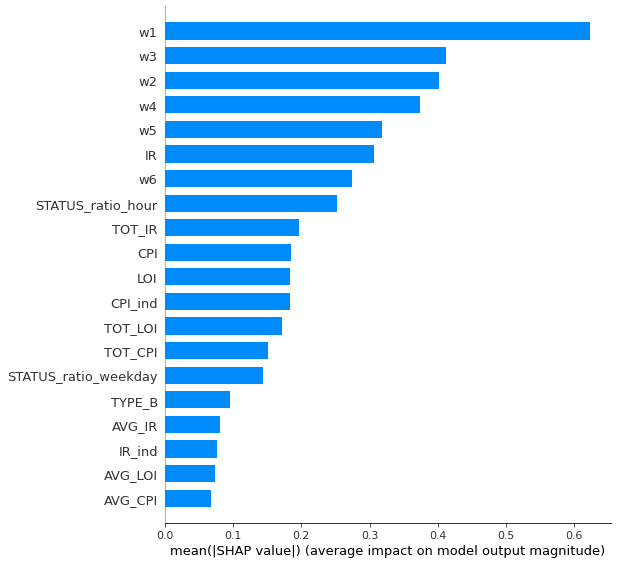

In [131]:
import shap

# DF, based on which importance is checked
X_importance = X_test

# Explain model predictions using shap library:
model = CatBoostClassifier(random_state=42).fit(X_train, y_train)
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_importance)
# Plot summary_plot as barplot:
shap.summary_plot(shap_values, X_importance, plot_type='bar')

In [132]:
shap_sum = np.abs(shap_values).mean(axis=0)
importance_df = pd.DataFrame([X_importance.columns.tolist(), shap_sum.tolist()]).T
importance_df.columns = ['column_name', 'shap_importance']
importance_df = importance_df.sort_values('shap_importance', ascending=False)
importance_df

,column_name,shap_importance
11,w1,0.622808
14,w3,0.412398
25,w2,0.401088
23,w4,0.374056
16,w5,0.318697
...,...,...
314,KMeans_15,0.0
59,SQ2_1939,0.0
60,SQ2_1940,0.0
61,SQ2_1941,0.0


In [133]:
features_selected = importance_df.query('shap_importance > 0').column_name.tolist()
X_train = X_train[features_selected]
X_test = X_test[features_selected]
#X_valid = X_valid[features_selected]
X_train.shape, X_test.shape#, X_valid.shape

((1170545, 321), (1355517, 321))

In [134]:
len(set(test.userID.unique()) - set(before_train.userID.unique()))
# 비포 트레인에 없는 ID => 총 3천개
# 트레인에 없는 ID => 총 4백개
# tr_test에 없는 ID => 총 1700개

2569

# 6. Modeling

In [135]:
# Set Dataset
train_X, valid_X, train_y, valid_y = train_test_split(X_train, y_train, test_size=0.3, random_state=42)

In [136]:
train_X.shape, valid_X.shape, train_y.shape, valid_y.shape

((819381, 321), (351164, 321), (819381,), (351164,))

In [137]:
gc.collect()

4888

### CatBoost

In [138]:
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import StratifiedKFold

In [139]:

model = CatBoostClassifier(random_state=42)

    
model.fit(train_X, train_y)
    
pred= model.predict(valid_X)
pred_proba = model.predict_proba(valid_X)[:,1]
    
score = roc_auc_score(valid_y, pred_proba)

Learning rate set to 0.180714
0:	learn: 0.5584147	total: 117ms	remaining: 1m 57s
1:	learn: 0.4768240	total: 213ms	remaining: 1m 46s
2:	learn: 0.4340972	total: 323ms	remaining: 1m 47s
3:	learn: 0.4067200	total: 420ms	remaining: 1m 44s
4:	learn: 0.3849648	total: 518ms	remaining: 1m 43s
5:	learn: 0.3713395	total: 615ms	remaining: 1m 41s
6:	learn: 0.3618391	total: 714ms	remaining: 1m 41s
7:	learn: 0.3544419	total: 833ms	remaining: 1m 43s
8:	learn: 0.3500831	total: 945ms	remaining: 1m 44s
9:	learn: 0.3462845	total: 1.05s	remaining: 1m 43s
10:	learn: 0.3435001	total: 1.15s	remaining: 1m 43s
11:	learn: 0.3411587	total: 1.25s	remaining: 1m 42s
12:	learn: 0.3389358	total: 1.35s	remaining: 1m 42s
13:	learn: 0.3371973	total: 1.45s	remaining: 1m 42s
14:	learn: 0.3354791	total: 1.55s	remaining: 1m 41s
15:	learn: 0.3344139	total: 1.66s	remaining: 1m 41s
16:	learn: 0.3331903	total: 1.75s	remaining: 1m 41s
17:	learn: 0.3323618	total: 1.88s	remaining: 1m 42s
18:	learn: 0.3315292	total: 2s	remaining: 1m

158:	learn: 0.3016414	total: 17.3s	remaining: 1m 31s
159:	learn: 0.3015737	total: 17.4s	remaining: 1m 31s
160:	learn: 0.3015347	total: 17.6s	remaining: 1m 31s
161:	learn: 0.3014621	total: 17.7s	remaining: 1m 31s
162:	learn: 0.3014077	total: 17.8s	remaining: 1m 31s
163:	learn: 0.3013602	total: 17.9s	remaining: 1m 31s
164:	learn: 0.3013045	total: 18s	remaining: 1m 30s
165:	learn: 0.3012474	total: 18.1s	remaining: 1m 30s
166:	learn: 0.3011711	total: 18.2s	remaining: 1m 30s
167:	learn: 0.3010804	total: 18.3s	remaining: 1m 30s
168:	learn: 0.3010358	total: 18.4s	remaining: 1m 30s
169:	learn: 0.3009506	total: 18.5s	remaining: 1m 30s
170:	learn: 0.3008213	total: 18.6s	remaining: 1m 30s
171:	learn: 0.3007770	total: 18.7s	remaining: 1m 30s
172:	learn: 0.3007187	total: 18.8s	remaining: 1m 29s
173:	learn: 0.3006668	total: 18.9s	remaining: 1m 29s
174:	learn: 0.3005708	total: 19s	remaining: 1m 29s
175:	learn: 0.3005156	total: 19.1s	remaining: 1m 29s
176:	learn: 0.3004436	total: 19.2s	remaining: 1m 2

314:	learn: 0.2935998	total: 35.2s	remaining: 1m 16s
315:	learn: 0.2935768	total: 35.3s	remaining: 1m 16s
316:	learn: 0.2935289	total: 35.4s	remaining: 1m 16s
317:	learn: 0.2934977	total: 35.5s	remaining: 1m 16s
318:	learn: 0.2934676	total: 35.6s	remaining: 1m 16s
319:	learn: 0.2934272	total: 35.7s	remaining: 1m 15s
320:	learn: 0.2933937	total: 35.9s	remaining: 1m 15s
321:	learn: 0.2933534	total: 36s	remaining: 1m 15s
322:	learn: 0.2932842	total: 36.1s	remaining: 1m 15s
323:	learn: 0.2932545	total: 36.2s	remaining: 1m 15s
324:	learn: 0.2932177	total: 36.3s	remaining: 1m 15s
325:	learn: 0.2931586	total: 36.4s	remaining: 1m 15s
326:	learn: 0.2931345	total: 36.5s	remaining: 1m 15s
327:	learn: 0.2931160	total: 36.6s	remaining: 1m 14s
328:	learn: 0.2930812	total: 36.7s	remaining: 1m 14s
329:	learn: 0.2930474	total: 36.8s	remaining: 1m 14s
330:	learn: 0.2930044	total: 36.9s	remaining: 1m 14s
331:	learn: 0.2929696	total: 37s	remaining: 1m 14s
332:	learn: 0.2929145	total: 37.1s	remaining: 1m 1

472:	learn: 0.2882658	total: 52.5s	remaining: 58.5s
473:	learn: 0.2882110	total: 52.6s	remaining: 58.4s
474:	learn: 0.2881837	total: 52.7s	remaining: 58.3s
475:	learn: 0.2881539	total: 52.9s	remaining: 58.2s
476:	learn: 0.2881189	total: 53s	remaining: 58.1s
477:	learn: 0.2880983	total: 53.1s	remaining: 58s
478:	learn: 0.2880743	total: 53.2s	remaining: 57.9s
479:	learn: 0.2880480	total: 53.3s	remaining: 57.7s
480:	learn: 0.2880249	total: 53.4s	remaining: 57.6s
481:	learn: 0.2880030	total: 53.5s	remaining: 57.5s
482:	learn: 0.2879840	total: 53.6s	remaining: 57.4s
483:	learn: 0.2879464	total: 53.7s	remaining: 57.3s
484:	learn: 0.2879138	total: 53.8s	remaining: 57.2s
485:	learn: 0.2878801	total: 53.9s	remaining: 57s
486:	learn: 0.2878404	total: 54.1s	remaining: 56.9s
487:	learn: 0.2878051	total: 54.2s	remaining: 56.8s
488:	learn: 0.2877830	total: 54.3s	remaining: 56.7s
489:	learn: 0.2877356	total: 54.4s	remaining: 56.6s
490:	learn: 0.2877094	total: 54.5s	remaining: 56.5s
491:	learn: 0.2876

632:	learn: 0.2842069	total: 1m 10s	remaining: 40.6s
633:	learn: 0.2841960	total: 1m 10s	remaining: 40.5s
634:	learn: 0.2841776	total: 1m 10s	remaining: 40.4s
635:	learn: 0.2841550	total: 1m 10s	remaining: 40.3s
636:	learn: 0.2841240	total: 1m 10s	remaining: 40.1s
637:	learn: 0.2841064	total: 1m 10s	remaining: 40s
638:	learn: 0.2840887	total: 1m 10s	remaining: 39.9s
639:	learn: 0.2840685	total: 1m 10s	remaining: 39.8s
640:	learn: 0.2840411	total: 1m 10s	remaining: 39.7s
641:	learn: 0.2840181	total: 1m 11s	remaining: 39.6s
642:	learn: 0.2839991	total: 1m 11s	remaining: 39.5s
643:	learn: 0.2839788	total: 1m 11s	remaining: 39.4s
644:	learn: 0.2839602	total: 1m 11s	remaining: 39.3s
645:	learn: 0.2839330	total: 1m 11s	remaining: 39.1s
646:	learn: 0.2839035	total: 1m 11s	remaining: 39s
647:	learn: 0.2838878	total: 1m 11s	remaining: 38.9s
648:	learn: 0.2838749	total: 1m 11s	remaining: 38.8s
649:	learn: 0.2838560	total: 1m 11s	remaining: 38.7s
650:	learn: 0.2838366	total: 1m 11s	remaining: 38.

788:	learn: 0.2808639	total: 1m 27s	remaining: 23.3s
789:	learn: 0.2808458	total: 1m 27s	remaining: 23.2s
790:	learn: 0.2808239	total: 1m 27s	remaining: 23.1s
791:	learn: 0.2808044	total: 1m 27s	remaining: 23s
792:	learn: 0.2807788	total: 1m 27s	remaining: 22.9s
793:	learn: 0.2807652	total: 1m 27s	remaining: 22.8s
794:	learn: 0.2807518	total: 1m 27s	remaining: 22.7s
795:	learn: 0.2807208	total: 1m 27s	remaining: 22.5s
796:	learn: 0.2807047	total: 1m 28s	remaining: 22.4s
797:	learn: 0.2806899	total: 1m 28s	remaining: 22.3s
798:	learn: 0.2806659	total: 1m 28s	remaining: 22.2s
799:	learn: 0.2806436	total: 1m 28s	remaining: 22.1s
800:	learn: 0.2806191	total: 1m 28s	remaining: 22s
801:	learn: 0.2805912	total: 1m 28s	remaining: 21.9s
802:	learn: 0.2805610	total: 1m 28s	remaining: 21.8s
803:	learn: 0.2805317	total: 1m 28s	remaining: 21.7s
804:	learn: 0.2805121	total: 1m 28s	remaining: 21.6s
805:	learn: 0.2804965	total: 1m 29s	remaining: 21.4s
806:	learn: 0.2804805	total: 1m 29s	remaining: 21.

944:	learn: 0.2775985	total: 1m 44s	remaining: 6.1s
945:	learn: 0.2775450	total: 1m 44s	remaining: 5.99s
946:	learn: 0.2775317	total: 1m 45s	remaining: 5.88s
947:	learn: 0.2775078	total: 1m 45s	remaining: 5.77s
948:	learn: 0.2774931	total: 1m 45s	remaining: 5.66s
949:	learn: 0.2774759	total: 1m 45s	remaining: 5.55s
950:	learn: 0.2774585	total: 1m 45s	remaining: 5.44s
951:	learn: 0.2774402	total: 1m 45s	remaining: 5.33s
952:	learn: 0.2774216	total: 1m 45s	remaining: 5.21s
953:	learn: 0.2774054	total: 1m 45s	remaining: 5.1s
954:	learn: 0.2773890	total: 1m 45s	remaining: 4.99s
955:	learn: 0.2773768	total: 1m 46s	remaining: 4.88s
956:	learn: 0.2773306	total: 1m 46s	remaining: 4.77s
957:	learn: 0.2773146	total: 1m 46s	remaining: 4.66s
958:	learn: 0.2772947	total: 1m 46s	remaining: 4.55s
959:	learn: 0.2772790	total: 1m 46s	remaining: 4.44s
960:	learn: 0.2772609	total: 1m 46s	remaining: 4.33s
961:	learn: 0.2772424	total: 1m 46s	remaining: 4.22s
962:	learn: 0.2772352	total: 1m 46s	remaining: 4

NameError: name 'scores' is not defined

In [140]:
score

0.9429443527614216

In [ ]:
print(f'Catboost모델의 ROC_AUC 평균 성능:  {np.mean(scores):.4f}')

In [ ]:
print(roc_auc_score(valid_y,model.predict_proba(valid_X)[:,1]))

* 점수확인

In [141]:
from sklearn.metrics import *

def get_clf_eval(y_test, pred=None, pred_proba=None): 
    confusion = confusion_matrix(y_test, pred) 
    accuracy = accuracy_score(y_test, pred) 
    precision = precision_score(y_test, pred) 
    recall = recall_score(y_test, pred) 
    f1 = f1_score(y_test, pred) 
    # ROC AUC 
    roc_auc = roc_auc_score(y_test, pred_proba) 
    
    print('Confusion Matrix') 
    print(confusion) 
    print('accuracy: {0:.4f}, precision: {1:.4f}, recall: {2:.4f}, f1: {3:.4f}, roc_auc: {4:.4f}'.format( accuracy, precision, recall, f1, roc_auc))

In [142]:
get_clf_eval(valid_y,pred,pred_proba)

Confusion Matrix
[[201980  23899]
 [ 21939 103346]]
accuracy: 0.8695, precision: 0.8122, recall: 0.8249, f1: 0.8185, roc_auc: 0.9429


# 7. Submission

In [143]:
pd.DataFrame({'ID': ID, 'STATUS':  model.predict_proba(X_test)[:,1]}).to_csv('Catboost_0.89732.csv', index=False)